### TikTok App Reviews

In [31]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re 
from wordcloud import WordCloud
from collections import Counter
import nltk
import torch
from gensim import corpora, models
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import nltk
import matplotlib.pyplot as plt
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
from transformers import BertModel, BertTokenizer
import seaborn as sns


In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
reviewsDataset = pd.read_csv('tiktok_app_reviews.csv',dtype={'app_version': str},low_memory=False)

In [8]:
reviewsDataset.head()

,review_id,review_text,upvotes,app_version,posted_date
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,It is an excellent solution to finding videos ...,402,21.2.5,2021-09-20 07:50:23
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,Great app works really well so many features s...,67,21.2.5,2021-09-19 23:10:47
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,I down loaded app but didnt work . i love this...,24,21.2.5,2021-09-19 08:59:34
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,18,21.2.5,2021-09-19 16:34:43
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,Currently it's working good for me except a fe...,232,21.1.41,2021-09-14 06:35:02


In [9]:
reviewsDataset.shape

(3646476, 5)

In [10]:
reviewsDataset['posted_date'] = pd.to_datetime(reviewsDataset['posted_date'])

In [11]:
reviewsDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646476 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   review_text  object        
 2   upvotes      int64         
 3   app_version  object        
 4   posted_date  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 139.1+ MB


#### Data Cleaning and Pre-processing

Missing values and duplicate rows:

In [12]:
duplicate_rows = reviewsDataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

missing_value_rows = reviewsDataset.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {missing_value_rows}")

Number of duplicate rows: 0
Number of rows with missing values: 993408


In [13]:
missing_values_count = reviewsDataset.isnull().sum()
missing_percent = (reviewsDataset.isnull().sum() / len(reviewsDataset)) * 100

# Printing the number of missing values for each column
print("Missing values count column-wise:")
print(missing_values_count[missing_values_count > 0])

print("\nPercentage of data missing in each column:")
print(missing_percent[missing_percent > 0])

Missing values count column-wise:
review_text       163
app_version    993269
dtype: int64

Percentage of data missing in each column:
review_text     0.004470
app_version    27.239148
dtype: float64


Removing the missing values from the review_text column but keeping the values as it is in the app_version column.   
We can consider either analysing the text with or without the app_version column.   
We can further analyse just the rows which have app version to identify any trends/patterns if they exist.


In [14]:
reviewsDataset.dropna(subset=['review_text'], inplace=True)

missing_values_check = reviewsDataset.isnull().sum()
print("Missing values count after dropping missing 'review_text':")
print(missing_values_check[missing_values_check > 0])


Missing values count after dropping missing 'review_text':
app_version    993245
dtype: int64


Only the missing values in the app_version remain

In [15]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # Removing any URL's if present
    text = re.sub('<.*?>+', '', text) # Remove any html tags if present
    text = re.sub('\n', '', text) # Convert to single line text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ascii characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatize
    return text

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Applying text preprocessing
reviewsDataset['review_text'] = reviewsDataset['review_text'].apply(preprocess_text)


In [16]:
reviewsDataset.head()

,review_id,review_text,upvotes,app_version,posted_date
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,excellent solution finding video following peo...,402,21.2.5,2021-09-20 07:50:23
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,great app work really well many feature many n...,67,21.2.5,2021-09-19 23:10:47
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,loaded app didnt work love app could maybe fix...,24,21.2.5,2021-09-19 08:59:34
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,great app fun use however arbitrary algorithm ...,18,21.2.5,2021-09-19 16:34:43
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,currently working good except clip video worke...,232,21.1.41,2021-09-14 06:35:02


#### EDA

In [17]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### VADER sentiment intensity analyzer

In [18]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:  # Positive sentiment
        return 'positive'
    elif score < -0.05:  # Negative sentiment
        return 'negative'
    else:  # Neutral sentiment
        return 'neutral'

# Applying VADER sentiment analysis
reviewsDataset['sentiment'] = reviewsDataset['review_text'].apply(get_vader_sentiment)

In [19]:
reviewsDataset.head()

,review_id,review_text,upvotes,app_version,posted_date,sentiment
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,excellent solution finding video following peo...,402,21.2.5,2021-09-20 07:50:23,positive
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,great app work really well many feature many n...,67,21.2.5,2021-09-19 23:10:47,positive
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,loaded app didnt work love app could maybe fix...,24,21.2.5,2021-09-19 08:59:34,positive
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,great app fun use however arbitrary algorithm ...,18,21.2.5,2021-09-19 16:34:43,positive
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,currently working good except clip video worke...,232,21.1.41,2021-09-14 06:35:02,negative


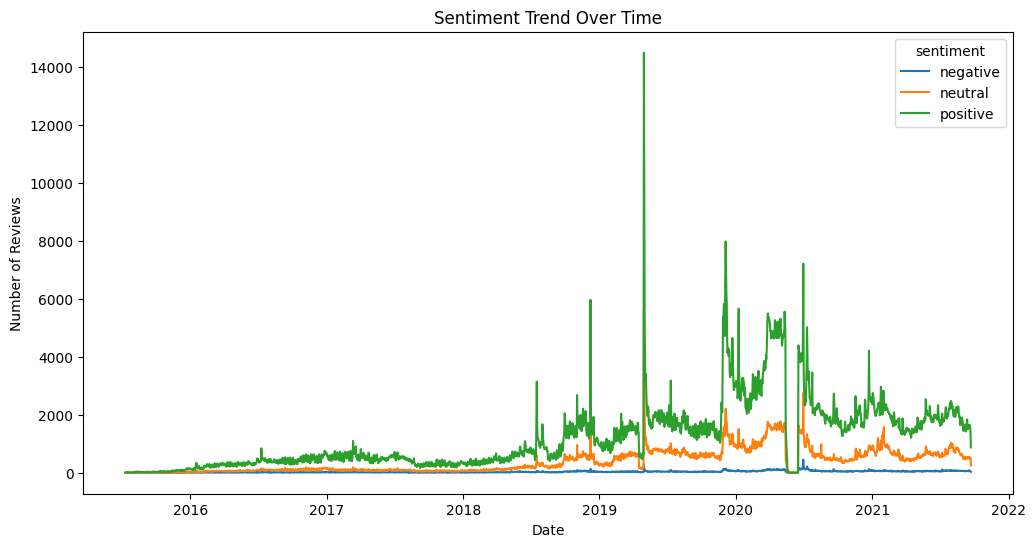

In [20]:
# Aggregating data by date and sentiment
trend_data = reviewsDataset.groupby([reviewsDataset['posted_date'].dt.date, 'sentiment']).size().unstack(fill_value=0)

# Plotting the trend
trend_data.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

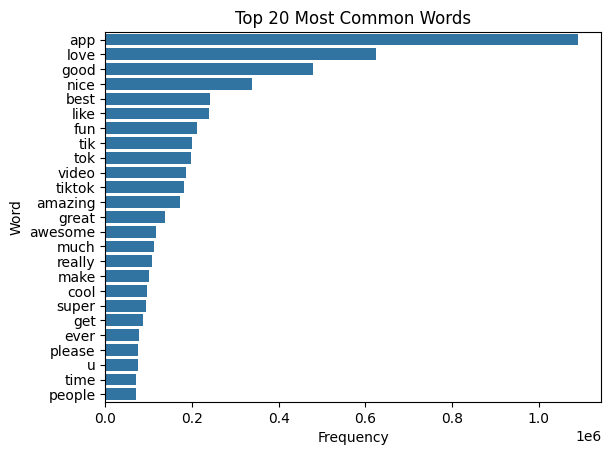

In [21]:
# Tokenization and word frequency calculation
words = ' '.join(reviewsDataset['review_text']).split()
word_counts = Counter(words)

# Most common words?
common_words = word_counts.most_common(25)

# Plotting
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Most Common Words')
plt.show()


In [22]:
# Mapping sentiment to a numeric scale (optional, based on analysis needs)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
reviewsDataset['sentiment_numeric'] = reviewsDataset['sentiment'].map(sentiment_map)

# Correlation analysis
correlation = reviewsDataset[['upvotes', 'sentiment_numeric']].corr()

print("Correlation between upvotes and sentiment:")
print(correlation)


Correlation between upvotes and sentiment:
                    upvotes  sentiment_numeric
upvotes            1.000000           0.005273
sentiment_numeric  0.005273           1.000000


Class Distribution:

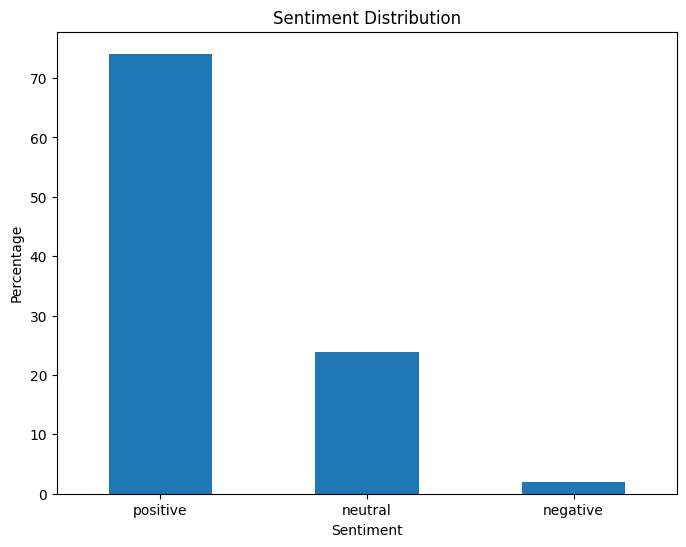

In [23]:
sentiment_distribution = reviewsDataset['sentiment'].value_counts(normalize=True) * 100

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=0) 
plt.show()

<Figure size 1500x800 with 0 Axes>

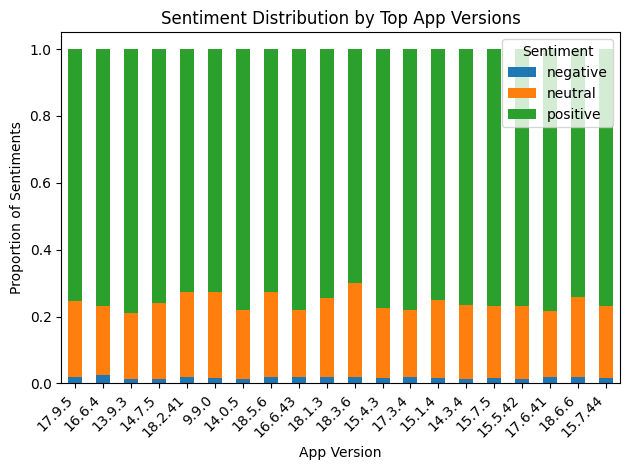

In [24]:
# Aggregating sentiment by app version
app_version_sentiment = reviewsDataset.groupby('app_version')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
top_versions = reviewsDataset['app_version'].value_counts().nlargest(20).index
filtered_data = app_version_sentiment.loc[top_versions]

# Plotting the sentiment distribution for the top app versions
plt.figure(figsize=(15, 8))  # Increase figure size for better readability
filtered_data.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Top App Versions')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('App Version')
plt.ylabel('Proportion of Sentiments')
plt.legend(title='Sentiment')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


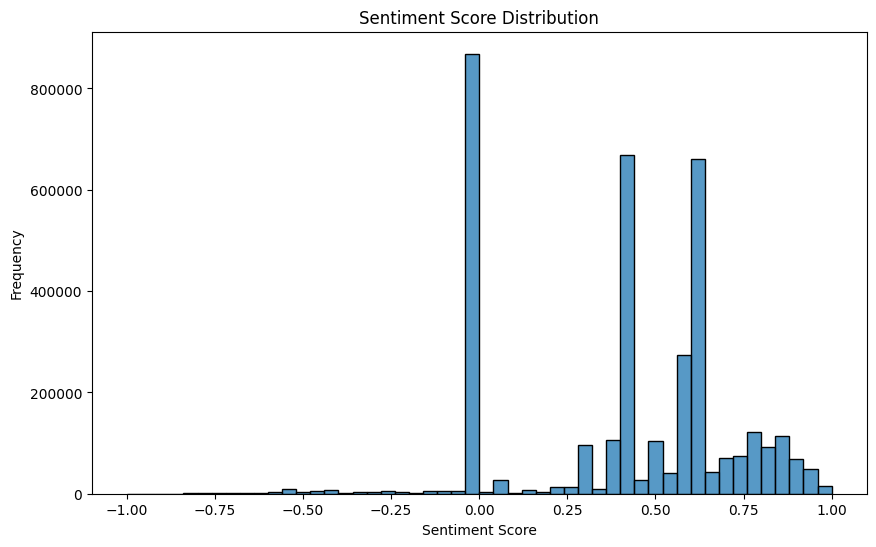

In [25]:
sia = SentimentIntensityAnalyzer()
reviewsDataset['sentiment_score'] = reviewsDataset['review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plotting the sentiment score distribution
plt.figure(figsize=(10, 6))
sns.histplot(reviewsDataset['sentiment_score'], bins=50, kde=False)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


### Feature Extraction 

#### BERT 


In [27]:
def tokenize_texts(texts, tokenizer, max_length=512):
    return [tokenizer(text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt") for text in texts]

# Function to extract features
def extract_features(encoded_texts, model, device):
    model.eval()
    model.to(device)
    features = []

    with torch.no_grad():
        for encoded_text in encoded_texts:
            input_ids = encoded_text['input_ids'].to(device)
            attention_mask = encoded_text['attention_mask'].to(device)
            output = model(input_ids, attention_mask=attention_mask)
            features.append(output.last_hidden_state[:,0,:].detach().cpu().numpy())
    features = np.vstack(features)
    return features
def bert_feature_extraction(texts, model_name='bert-base-uncased', batch_size=32):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    features = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokenized_texts = tokenize_texts(batch_texts, tokenizer)
        batch_features = extract_features(tokenized_texts, model, device)
        features.append(batch_features)
    features = np.vstack(features)
    features_df = pd.DataFrame(features)
    return features_df


In [32]:
sample_texts = reviewsDataset['review_text'][:10].tolist() 
bert_features_df = bert_feature_extraction(sample_texts)
reviewsDataset_bert = reviewsDataset[:10].join(bert_features_df)
reviewsDataset_bert.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\devuj\anaconda3\envs\tensorflow_gpu\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\devuj\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

,review_id,review_text,upvotes,app_version,posted_date,sentiment,sentiment_numeric,sentiment_score,0,1,...,758,759,760,761,762,763,764,765,766,767
0,gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...,excellent solution finding video following peo...,402,21.2.5,2021-09-20 07:50:23,positive,1,0.9524,-0.179065,0.203405,...,-0.290796,-0.645663,-0.017522,0.047931,-0.059548,-0.246356,0.099235,-0.524268,0.112594,0.479265
1,gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...,great app work really well many feature many n...,67,21.2.5,2021-09-19 23:10:47,positive,1,0.9828,-0.153612,-0.039287,...,0.173922,-0.553772,0.137671,0.220792,0.442595,0.036940,-0.225376,-0.377909,-0.175259,-0.000150
2,gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...,loaded app didnt work love app could maybe fix...,24,21.2.5,2021-09-19 08:59:34,positive,1,0.8415,-0.289208,0.189449,...,0.006683,-0.477721,0.323896,0.217742,0.242239,0.102750,-0.134632,-0.799443,0.231517,0.427977
3,gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...,great app fun use however arbitrary algorithm ...,18,21.2.5,2021-09-19 16:34:43,positive,1,0.8720,0.007291,0.106518,...,-0.187318,-0.401200,-0.249922,-0.048913,0.257055,0.050896,-0.271289,-0.434148,0.228405,0.342699
4,gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...,currently working good except clip video worke...,232,21.1.41,2021-09-14 06:35:02,negative,-1,-0.4614,-0.451031,0.073649,...,0.166171,-0.565123,0.137808,0.195580,0.191488,0.302790,-0.119977,-0.684306,0.262710,0.138893


Sentiments are categorized as positive or negative, with corresponding numeric and score values indicating the strength of the sentiment. 

The reviews cover various aspects of the app's performance, features, and user experience, with sentiment scores ranging from highly positive (0.9828) to negative (-0.4614).

### Named Entity Recognition

In [33]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [34]:
def extract_named_entities(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    named_entities_tree = ne_chunk(tagged_tokens)
    named_entities = []
    for tree in named_entities_tree:
        if hasattr(tree, 'label'):
            entity_name = ' '.join(c[0] for c in tree.leaves())  
            entity_type = tree.label()  
            named_entities.append((entity_name, entity_type))
    
    return named_entities
text = "Apple Inc. is looking at buying U.K. startup for $1 billion"
named_entities = extract_named_entities(text)
print(named_entities)


[('Apple', 'PERSON'), ('Inc.', 'ORGANIZATION')]


### Topic Modeling/Trends
- Latent Dirichlet Allocation (LDA)

In [35]:
texts = [[word for word in document.lower().split()] for document in reviewsDataset['review_text'].head(1000)]

# Create a corpus from a list of texts
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=15)

# Print topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.023*"video" + 0.017*"app" + 0.017*"good" + 0.016*"like" + 0.014*"people"')
(1, '0.043*"video" + 0.040*"app" + 0.023*"great" + 0.020*"fun" + 0.016*"make"')
(2, '0.041*"app" + 0.020*"love" + 0.014*"fun" + 0.014*"people" + 0.013*"get"')
(3, '0.047*"app" + 0.037*"video" + 0.026*"fun" + 0.024*"love" + 0.015*"watch"')
(4, '0.040*"app" + 0.022*"like" + 0.018*"make" + 0.017*"really" + 0.015*"people"')
(5, '0.043*"app" + 0.023*"video" + 0.021*"love" + 0.020*"like" + 0.018*"tiktok"')
(6, '0.052*"app" + 0.021*"like" + 0.019*"dont" + 0.015*"great" + 0.012*"love"')
(7, '0.027*"people" + 0.017*"video" + 0.016*"love" + 0.015*"time" + 0.014*"amazing"')
(8, '0.041*"app" + 0.015*"love" + 0.011*"one" + 0.010*"thing" + 0.009*"like"')
(9, '0.028*"love" + 0.025*"app" + 0.014*"friend" + 0.014*"video" + 0.012*"thing"')


This indicates a diverse range of discussions or reviews related to the app's various aspects, from content creation and enjoyment to technical feedback.

In [36]:
nltk.download('wordnet')

def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
documents = reviewsDataset['review_text']
processed_docs = documents.map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')


Topic: 0 
Words: 0.267*"music" + 0.023*"khan" + 0.021*"updat" + 0.020*"favorit" + 0.018*"star" + 0.018*"better" + 0.016*"kumar" + 0.016*"want" + 0.012*"year" + 0.010*"daughter"

Topic: 1 
Words: 0.084*"thank" + 0.069*"tiktok" + 0.036*"live" + 0.021*"help" + 0.019*"bhai" + 0.015*"singh" + 0.015*"account" + 0.014*"dope" + 0.012*"hard" + 0.012*"problem"

Topic: 2 
Words: 0.744*"love" + 0.109*"great" + 0.012*"awsm" + 0.008*"express" + 0.007*"ilov" + 0.006*"musiclli" + 0.006*"creativ" + 0.006*"excel" + 0.005*"king" + 0.005*"soooo"

Topic: 3 
Words: 0.191*"video" + 0.122*"song" + 0.070*"easi" + 0.045*"make" + 0.027*"nise" + 0.026*"post" + 0.022*"watch" + 0.021*"qualiti" + 0.018*"sync" + 0.018*"naic"

Topic: 4 
Words: 0.530*"best" + 0.068*"supper" + 0.067*"entertain" + 0.025*"bore" + 0.022*"social" + 0.019*"recommend" + 0.016*"total" + 0.016*"semma" + 0.013*"use" + 0.012*"medium"

Topic: 5 
Words: 0.312*"awesom" + 0.098*"addict" + 0.073*"time" + 0.068*"game" + 0.067*"download" + 0.038*"work" 

The topics extracted from the text data underscore diverse aspects of user engagement on the social media platform TikTok. These encompass appreciation for music and celebrities, expressions of gratitude and support for the app, overwhelmingly positive sentiments such as love and admiration, and discussions regarding content creation, entertainment value, engagement, and downloads. Additional themes include fun and amusement, positive feedback, social connectivity, and opinions on social dynamics. Collectively, these topics depict a lively community that prioritizes creativity, entertainment, social interaction, and the platform's contribution to enriching their digital and social experiences.

# Based on the analyses conducted:

1. **Most Praised Features:**
   - Music-related content receives high praise, indicating a strong user interest in this aspect.
   - Positive sentiments towards content creation tools and ease of use.
   - Appreciation for entertainment value and addictive nature of the app.
   - Positive feedback on app functionality, including smooth performance and user interface.

2. **Common Complaints:**
   - Limited mentions of specific complaints, but negative sentiment towards content quality and boredom.
   - Some users experience technical issues, such as video clipping problems.
   - Some dissatisfaction with algorithmic decisions, possibly affecting user experience negatively.

3. **Suggested Improvements:**
   - Enhance content quality control measures to address complaints about boring or repetitive content.
   - Improve technical performance to resolve issues like video clipping and algorithmic decision-making.
   - Incorporate user feedback mechanisms to better understand and address user concerns.

**Recommendations for Product Development and Customer Satisfaction Improvement:**
   - Focus on enhancing music-related features and content to capitalize on positive sentiments in this area.
   - Prioritize technical improvements to resolve reported issues and ensure a smoother user experience.
   - Implement user feedback loops to gather insights continually and iteratively improve the app based on user preferences and needs.
   - Invest in quality control measures to maintain a high standard of content and address user complaints about boredom or repetitive content.

By implementing these strategies, the app can enhance its offerings, address user concerns, and ultimately improve customer satisfaction, leading to increased user engagement and loyalty.